# Machine Learning for Cybersecurity - Lab 01
## Email spam filtering

## Student details
* `Name`: Sukriti Macker
* `NETID`: sm11017

_______

## Assignment details

### Overview

In this lab, you will design an e-mail spam filter using a Naive Bayes and SVM based classification on the ling-spam dataset. You will explore the impact of feature selection and compare the performance of different variants of an NB classifier and also implement your own SVM based classifier. (Note: You may use the scikitt learn classifiers to only compare the accuracy
of their model to yours).

### Dataset

The ling-spam corpus contains e-mails from the Linguist mailing list categorized as either legitimate or spam emails. The corpus is divided into four sub-folders that contain the same emails that are pre-processed with/without lemmatization and with/without stop-word removal. The e-mails in each sub-folder partitioned into 10 "folds."

In this lab, we will use the first 9 folds from the ling-spam corpus as training data, and the $10^{th}$ fold as test data.

### What you have to do

You will implement your e-mail spam filters in Python. You are free to use any Python libraries that are relevant to the problem.

* Download the ling-spam dataset from http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz

Please use the "lingspam_public01' corpus with both lemmatization and stop-word enabled (under the lemm_stop folder).

* Your first goal is to perform feature selection using the information gain (IG) metric. From the training data, select the top-N features for N = {10, 100, 1000}. Note that feature selection based on the IG metric only accounts for the occurrence of (and not frequency with which terms appear) in the dataset.

* Next, implement the following classifiers -
  * Bernoulli NB classifier with binary features;
  * Multinomial NB with binary features, and
  * Multinomial NB with term frequency (TF) features.

* For each of the three classifiers above and for N = {10, 100, 1000} report the spam precision and spam recall. Spam precision is defined as the fraction of true spam e-mails among all e-mails predicted as spam, and spam recall is defined as fraction of true spam e-mails predicted as spam. Also report the latency of each model.
* Implement a Support Vector Machine (SVM) based spam filter. This problem is open ended: for instance, you can choose to use either BF or TF and any feature selection method. Note that you should NOT use the test dataset in picking the hyper-parameters of your spam filter, instead use cross-validation on the training dataset.

### What to submit

* Your Python code in the form of a Google Colab notebook. Please also include a PDF of your colab notebook.
* Your Colab notebook should print:
* a list of the top-10 words identified from Part (1) above, and
* a list of spam precision and spam recall values for each of the three classifiers for N = {10, 100, 1000}. That is, your list should have 9 rows, one for each classifier and N combination.
* For the SVM based spam filter, please describe your methodology, i.e., what kind of features you used, how many features you used and how you selected them, the parameters of the SVM and finally the precision and recall on
the test dataset.

## Part 0: Preprocessing

In [1]:
## import required packages

import math
import numpy as np
import pandas as pd
import os
import string
import re
from tqdm.notebook import tqdm
import seaborn as sns
import copy
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Loading the dataset and processing the data

In [10]:
!wget "http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz" -O lingspam_public.tar.gz --no-check-certificate

--2023-11-01 03:36:42--  http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www.aueb.gr (www.aueb.gr)... 195.251.255.156
Connecting to www.aueb.gr (www.aueb.gr)|195.251.255.156|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://pages.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2023-11-01 03:36:43--  http://pages.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving pages.aueb.gr (pages.aueb.gr)... 195.251.255.230
Connecting to pages.aueb.gr (pages.aueb.gr)|195.251.255.230|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2023-11-01 03:36:44--  https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www2.aueb.gr (www2.aueb.gr)... 195.251.255.230
Connecting to www2.aueb.gr (www2.aueb.gr)|195.251.255.230|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request 

In [11]:
!tar -xvzf "lingspam_public.tar.gz"

Streaming output truncated to the last 5000 lines.
lingspam_public/lemm_stop/part2/6-1037msg3.txt
lingspam_public/lemm_stop/part2/6-1039msg1.txt
lingspam_public/lemm_stop/part2/6-1040msg1.txt
lingspam_public/lemm_stop/part2/6-1041msg1.txt
lingspam_public/lemm_stop/part2/6-1044msg1.txt
lingspam_public/lemm_stop/part2/6-1045msg1.txt
lingspam_public/lemm_stop/part2/6-1047msg1.txt
lingspam_public/lemm_stop/part2/6-1048msg1.txt
lingspam_public/lemm_stop/part2/6-1049msg1.txt
lingspam_public/lemm_stop/part2/6-1050msg1.txt
lingspam_public/lemm_stop/part2/6-1050msg2.txt
lingspam_public/lemm_stop/part2/6-1050msg3.txt
lingspam_public/lemm_stop/part2/6-1051msg1.txt
lingspam_public/lemm_stop/part2/6-1052msg1.txt
lingspam_public/lemm_stop/part2/6-1055msg1.txt
lingspam_public/lemm_stop/part2/6-1056msg1.txt
lingspam_public/lemm_stop/part2/spmsga142.txt
lingspam_public/lemm_stop/part2/spmsga143.txt
lingspam_public/lemm_stop/part2/spmsga144.txt
lingspam_public/lemm_stop/part2/spmsga145.txt
lingspam_publ

In [12]:
# access files in the lemm_stop folder

train_dirs = sorted([os.path.join('lingspam_public/lemm_stop', f) for f in os.listdir('lingspam_public/lemm_stop') if not f.endswith('10')])
test_dir = 'lingspam_public/lemm_stop/part10'

In [13]:
train_dirs

['lingspam_public/lemm_stop/part1',
 'lingspam_public/lemm_stop/part2',
 'lingspam_public/lemm_stop/part3',
 'lingspam_public/lemm_stop/part4',
 'lingspam_public/lemm_stop/part5',
 'lingspam_public/lemm_stop/part6',
 'lingspam_public/lemm_stop/part7',
 'lingspam_public/lemm_stop/part8',
 'lingspam_public/lemm_stop/part9']

In [14]:
PUNCTUATIONS = string.punctuation

def clean(data: str) -> list[str]:
    '''
    Cleans given email and returns it as a list of words
    --------------------
    Sample email:
    --------------------
        - Subject: s - > np + np
        discussion s - > np + np remind ago read , source forget , critique newsmagazine ' unique tendency write style , most writer overly " cute " .
        one item tersely put down follow : " 's favorite : colon . " - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - lee hartman
        ga5123 @ siucvmb . bitnet department foreign language southern illinoi university carbondale , il 62901 u . s . .

    Sample cleaned output:
    --------------------
        - ['s', 'np', 'npdiscussion', 's', 'np', 'np', 'remind', 'ago', 'read', 'source', 'forget', 'critique', 'newsmagazine', 'unique', 'tendency', 'write',
        'style', 'most', 'writer', 'overly', 'cute', 'one', 'item', 'tersely', 'put', 'down', 'follow', 's', 'favorite', 'colon', 'lee', 'hartman', 'ga', 'siucvmb',
        'bitnet', 'department', 'foreign', 'language', 'southern', 'illinoi', 'university', 'carbondale', 'il', 'u', 's']
    '''
    data = data.lower()               # lowercase
    data = data.replace('\n','')      # removing new lines
    data = data.replace('\t','')      # removing tabs
    data = data.replace("subject",'') # removing subject as it exists in all email bodies
    data = re.sub(r"\d+", "", data)   # removing numbers
    for i in PUNCTUATIONS:
        data = data.replace(i,'')     # removing all punctuation
    data = data.split(' ')
    data = ' '.join(data).split()

    return data


def preprocess_data(dir_list: list[str]) -> dict:
  '''
  Inputs:
    - list of directories containing files with messages of any kind

  Returns:
    - dictionary containing processed data from all files in all directories
  '''
  cleaned_data = {}
  for dir in dir_list:
     for file_name in os.listdir(dir):
        with open(f'{dir}/{file_name}', 'r') as f:
          data = f.read()
          cleaned_data[f'{dir}/{file_name}'] = clean(data=data)

  return cleaned_data

In [15]:
# Preprocess the train and test data

train_emails = preprocess_data(dir_list=train_dirs)
test_emails = preprocess_data(dir_list=[test_dir])

print(f"Number of emails in training dataset: {len(train_emails)}")
print(f"Number of emails in test dataset: {len(test_emails)}")

Number of emails in training dataset: 2602
Number of emails in test dataset: 291


#### Getting the Feature List

In [16]:
def get_all_features(email_dict: dict) -> list[str]:
  '''
  Inputs:
    - dictionary of email files and corresponding list of words

  Returns:
    - list of all unique words present in the email files
  '''
  all_words = []
  for msg in email_dict.values():
    all_words += msg

  return list(set(all_words))

In [17]:
# Create list of all features (words)

feature_list = get_all_features(email_dict=train_emails)

print(f"Number of unique words present in the training emails: {len(feature_list)}")

Number of unique words present in the training emails: 49797


In [18]:
def segregate_emails(email_dict: dict) -> dict:
    '''
    Inputs:
        - email_dict: dictionary of emails to segregate

    Returns:
        - classified_emails: dictionary whose primary key is the email class with list of emails in that class
    '''
    classified_emails = {0: [], 1: []}
    for filename, email in email_dict.items():
        classified_emails[int('spm' in filename)].append(email)

    return classified_emails

In [19]:
classified_train_emails = segregate_emails(email_dict=train_emails)

num_spam_emails = len(classified_train_emails[1])
num_nonspam_emails = len(classified_train_emails[0])

print(f"Number of spam emails in train dataset: {num_spam_emails}")
print(f"Number of non-spam emails in train dataset: {num_nonspam_emails}")

Number of spam emails in train dataset: 432
Number of non-spam emails in train dataset: 2170


## Part 1: Feature selection using Information Gain

To do feature selection, we use the `Information Gain` metric based on the occurence of the word. For a specific word in the feature set, we can calculate the information gain using the following formula $:-$
$$
IG(C, w)=H(C)-H(C|w)
$$

where $H(X)$ is the entropy of the random variable $X$ which takes finite values, and $w$ is a word that belongs to the feature set.

For a binary variable $X \in \{0,1\}$ where $p:=P(X=1)$, the entropy $H(X)$ is calculated using $:$
$$
H(X)= -p \times log_2p - (1-p) \times log_2(1-p)
$$

In our case, $C$ is the random variable that indicates whether an email is a `spam` email $(C=1)$ or a `non-spam` email $(C=0)$.

### Part 1.1: Calculation of inherent entropy

To calculates $H(C)$, we need the prior probability of spam classification which is $P(C=1) \text{ which we use as } p$.

We can set the prior probability of spam emails to the `proportion` of spam emails present in the training set.

In [20]:
p_spam_prior = num_spam_emails / (num_spam_emails + num_nonspam_emails)

print(f"The prior probability of an email being classified as spam = {p_spam_prior}")

The prior probability of an email being classified as spam = 0.1660261337432744


In [21]:
def calculate_entropy_binary(prob: float) -> float:
    '''
    Inputs:
        - probability of positive classification of the binary variable

    Returns:
        - entropy value of the binary random variable
    '''
    return - prob * math.log(prob, 2) - (1-prob) * math.log(1-prob, 2)

In [22]:
# Calculate inherent entropy of classification using prior probability

inherent_entropy = calculate_entropy_binary(prob=p_spam_prior)
print(f"The inherent entropy of spam classification of a given email is: {inherent_entropy}")

The inherent entropy of spam classification of a given email is: 0.6485330171848536


### Part 1.2: Calculation of conditional entropy and information gain

Now, we need to calculate $H(C|X_i)$, where $C|X_i$ is the random variable that indicates whether the email is spam or not based on $X_i$ (which denotes the occurence of the $i^{th}$ word $w_i$).

This can be calculated using the following formula:

\begin{align*}
   H(C|X_i) &= \sum_{x\in \{0,1\}}P(X_i=x)H(C|X_i=x) \\
   &=\sum_{x\in\{0,1\}}-P(X_i=x)\sum_{c\in\{0,1\}}P(C=c|X_i=x)\log_2(P(C=c|X_i=x))\\
   &=-\sum_{x\in\{0,1\}}\sum_{c\in\{0,1\}}P(X_i=x)P(C=c|X_i=x)\log_2(P(C=c|X_i=x))\\
   &=-\sum_{x\in\{0,1\}}\sum_{c\in\{0,1\}}{P(X_i=x)}\left(\frac{P(X_i=x|C=c)P(C=c)}{{P(X_i=x)}}\right)\log_2(P(C=c|X_i=x))\\
   &=-\sum_{x\in\{0,1\}}\sum_{c\in\{0,1\}}P(X_i=x|C=c)P(C=c)\log_2(P(C=c|X_i=x))\\
   &=-\sum_{c\in\{0,1\}}P(C=c)\sum_{x\in\{0,1\}}P(X_i=x|C=c)\log_2(P(C=c|X_i=x))\\
   &=-\sum_{c\in\{0,1\}}P(C=c)\sum_{x\in\{0,1\}}P(X_i=x|C=c)\log_2\left(\frac{P(X_i=x|C=c)*P(C=c)}{P(X_i=x)}\right)\\
\end{align*}

Since, we have the posterior probabilities for classification of each word, we can calculate the `conditional entropy of classification` $H(C|w)$ given word $(w)$  using `calculate_entropy_binary` function.

Using these, we can calculate the `Information Gain` for a word $(w)$ as $$IG(C,w) = H(C) - H(C|w)$$

In [23]:
def calculate_occurence_prob(word: str, emails: list, num_emails: int) -> float:
    '''
    Inputs:
        - word: word to find in email
        - emails: list of emails to search the word
        - num_emails: total number of emails to search

    Caveats:
        - Laplace smoothing is used to calculate the probability of occurence (prob = (frequency + 1) / (total + 2))

    Returns:
        - probability of occurence of word in given emails
    '''
    word_freq = sum(1 if word in email else 0 for email in emails)
    return (word_freq + 1) / (num_emails + 2)

In [24]:
# Calculate probability of occurrence of the word in all emails and spam emails

word_info = dict.fromkeys(feature_list, {})
for word in tqdm(feature_list):
    p_spam = calculate_occurence_prob(word=word, emails=classified_train_emails[1], num_emails=num_spam_emails)
    p_nonspam = calculate_occurence_prob(word=word, emails=classified_train_emails[0], num_emails=num_nonspam_emails)
    p_overall = (p_spam * (num_spam_emails + 2) + p_nonspam * (num_nonspam_emails + 2) - 1) / (num_spam_emails + num_nonspam_emails + 2)
    word_info[word] = {'p_spam': p_spam, 'p_nonspam': p_nonspam, 'p_overall': p_overall}

  0%|          | 0/49797 [00:00<?, ?it/s]

Now we have the overall probabilities of word occurence and probabilities of occurence of the word in spam emails.
*Laplacian smoothing* has been used to calculate the probabilities as
- overall probabilities can't be $0$ (being the denominator of posterior probability calculation), and
- spam probabilities can't be $0$ (otherwise posterior probability would become $0$ creating issues in entropy calculation)

We can use these values to calculate the `posterior probability` of spam classification given the occurence of the word.

In [25]:
def calculate_conditional_entropy(p_spam: float, p_nonspam: float, p_overall: float, prior_prob: float=p_spam_prior):
    '''
    Inputs:
        - p_spam: probability of occurence of word in spam emails
        - p_nonspam: probability of occurence of word in non-spam emails
        - p_overall: probability of occurence of word in all emails
        - prior_spam: prior probability of spam classification

    Returns:
        - information gain of the word
    '''

    entropy_spam = prior_prob * (p_spam * math.log(p_spam * prior_prob / p_overall, 2) + (1 - p_spam) * math.log((1 - p_spam) * prior_prob / (1 - p_overall), 2))
    entropy_nonspam = (1 - prior_prob) * (p_nonspam * math.log(p_nonspam * (1 - prior_prob) / p_overall, 2) + (1 - p_nonspam) * math.log((1 - p_nonspam) * (1 - prior_prob) /  (1 - p_overall), 2))

    return - (entropy_spam + entropy_nonspam)

In [26]:
# Calculate information gain for every word

for word, info in word_info.items():
    # Calculate conditional entropy for word using probability of occurences
    conditional_entropy = calculate_conditional_entropy(
        p_spam=info['p_spam'],
        p_nonspam=info['p_nonspam'],
        p_overall=info['p_overall'],
    )
    # Subtract conditional entropy from inherent entropy to get information gain
    info['information_gain'] = inherent_entropy - conditional_entropy

### Part 1.3: Top N feature selection based on information gain

To get the top ***N*** words according to the Information gain values, we just sort the dataframe over `information_gain` in descending order and take the words corresponding to the first ***N*** rows

In [27]:
sorted_words_by_ig = sorted(word_info, key=lambda x: word_info[x].get('information_gain'), reverse=True)

top10_words = sorted_words_by_ig[:10]
top100_words = sorted_words_by_ig[:100]
top1000_words = sorted_words_by_ig[:1000]

## Part 2: Classifier Implementation

### Part 2.1: Creation of features

We need to create the (`binary` and `term frequency`) feature vectors for emails using the top N $\{10, 100, 1000\}$ words for the test dataset.

In [28]:
def get_vectorized_data(email_dict: dict) -> dict:
    '''
    Creates binary and term frequency features using top N words for all emails in the email dictionary

    Inputs:
      - email_dict: dictionary of emails for feature vector creation

    Returns:
      - featurized_dict: nested dictionary
      - Format: {
          filename: {
            'email': list[str],
            'binary_feature_10': list[int],
            'tf_feature_10': list[int],
            'binary_feature_100': list[int],
            'tf_feature_100': list[int],
            'binary_feature_1000': list[int],
            'tf_feature_1000': list[int],
            'actual_class': [0, 1]
          }
        }
    '''
    featurized_dict = {
        filename: {
            'email': email,
            'binary_feature_10': [],
            'tf_feature_10': [],
            'binary_feature_100': [],
            'tf_feature_100': [],
            'binary_feature_1000': [],
            'tf_feature_1000': [],
            'actual_class': int('spm' in filename)
        }
        for filename, email in email_dict.items()
    }

    top1000_words = sorted_words_by_ig[:1000]
    for filename, email in email_dict.items():
        for word in top1000_words:
            featurized_dict[filename]['binary_feature_1000'].append(int(word in email))
            featurized_dict[filename]['tf_feature_1000'].append(email.count(word))
        featurized_dict[filename]['binary_feature_10'] = featurized_dict[filename]['binary_feature_1000'][:10]
        featurized_dict[filename]['tf_feature_10'] = featurized_dict[filename]['tf_feature_1000'][:10]
        featurized_dict[filename]['binary_feature_100'] = featurized_dict[filename]['binary_feature_1000'][:100]
        featurized_dict[filename]['tf_feature_100'] = featurized_dict[filename]['tf_feature_1000'][:100]

    return featurized_dict

In [29]:
train_data_featurized = get_vectorized_data(email_dict=train_emails)
test_data_featurized = get_vectorized_data(email_dict=test_emails)

#### Displaying the features

In [30]:
def visualize_features(featurized_data: dict, feature_type: str) -> pd.DataFrame:
    '''
    Inputs:
        - featurized_data: nested dictionary
        - feature_type: [binary, tf]

    Returns:
        - visualizable dataframe
    '''
    first_file = list(featurized_data.keys())[0]
    first_feature_vector = featurized_data[first_file][feature_type]
    feature_words = top1000_words[:len(first_feature_vector)]

    return pd.DataFrame(
        [
            {'filename': filename, 'actual_class': contents['actual_class']} | {word: contents[feature_type][i] for i, word in enumerate(feature_words)}
            for filename, contents in featurized_data.items()
        ]
    )


def visualize_fields(featurized_data: dict, fields: list[str]) -> pd.DataFrame:
    '''
    Inputs:
        - featurized_data: nested dictionary
        - fields: list of column names

    Returns:
        - visualizable dataframe
    '''
    return pd.DataFrame({'filename': filename} | {field: contents.get(field) for field in fields} for filename, contents in featurized_data.items())

In [31]:
# Display feature vector and actual classes for the test dataset

visualize_fields(test_data_featurized, ['binary_feature_10', 'actual_class']).head(3)

,filename,binary_feature_10,actual_class
0,lingspam_public/lemm_stop/part10/9-660msg1.txt,"[1, 0, 0, 1, 1, 0, 0, 0, 1, 0]",0
1,lingspam_public/lemm_stop/part10/9-884msg2.txt,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0
2,lingspam_public/lemm_stop/part10/9-634msg1.txt,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]",0


In [32]:
# Display term frequency features for test dataset

visualize_features(test_data_featurized, 'tf_feature_10').head(3)

,filename,actual_class,language,remove,free,linguistic,university,money,click,market,our,business
0,lingspam_public/lemm_stop/part10/9-660msg1.txt,0,1,0,0,6,2,0,0,0,2,0
1,lingspam_public/lemm_stop/part10/9-884msg2.txt,0,1,0,0,1,0,0,0,0,1,0
2,lingspam_public/lemm_stop/part10/9-634msg1.txt,0,2,0,0,0,1,0,0,0,0,0


### Part 2.2: Bernoulli NB Classifier with binary features

For Bernoulli NB with binary features, we have $m$ attributes $F=\{t_1,\cdots, t_m\}$ in the dataset. We need to calculate the probability of occurace of each word in a given class $c$, which is $p(t_i|c)$. For each message, we can get $-$

$$
p(\overrightarrow{x}|c)=\prod_{i=1}^m p(t_i|c)^{x_i} (1-p(t_i|c))^{(1-x_i)}
$$

where $x_i\in \{0,1\}$ indicates the occurence and $\overrightarrow{x}$ represents the feature vector.

We can estimate whether the email is spam or not spam by using the formula $-$
$$
\frac{p(\overrightarrow{x}|c=1) p(c=1)}{\sum_{c \in \{0,1\}}p(\overrightarrow{x}|c) p(c)} > 0.5
$$

The LHS is the posterior probability of classification of the email as spam. The decision rule is based on classifying the email as the class that is more probable.

The above expression can be simplified as follows $:$

$$
\begin{gathered}
\Rightarrow \frac{p(\overrightarrow{x}|c=1) p(c=1)}{p(\overrightarrow{x}|c=1) p(c=1) + p(\overrightarrow{x}|c=0) p(c=0)} > \frac{1}{2}
\Rightarrow \frac{p(\overrightarrow{x}|c=1)p(c=1)}{p(\overrightarrow{x}|c=0)p(c=0)} > 1
\Rightarrow \frac{p\_spam\_prior}{1-p\_spam\_prior}\cdot\frac{\prod_{i=1}^m p(t_i|c=1)^{x_i} (1-p(t_i|c=1))^{1-x_i}}{\prod_{i=1}^m p(t_i|c=0)^{x_i} (1-p(t_i|c=0))^{1-x_i}} > 1
\end{gathered}
$$

$p(t|c)$ can be calculated by $-$

$$
p(t|c)=\frac{1+M_{t,c}}{2+M_c}
$$

Laplacian smoothing needs to be applied.

**NOTE:** $M_{t,c}$ is the number of tokens in class $c$ that contain token $t$. $M_c$ is the number of emails in class $c$

In [33]:
def classify_BernoulliNB_binary_features(feature_vector: list[int], spam_prob_vector: list[float], nonspam_prob_vector: list[float], prior_spam_prob: float=p_spam_prior) -> int:
    '''
    Inputs:
        - feature_vector: list of features created from words
        - spam_prob_vector: list of probabilities corresponding to feature_vector created from the spam class
        - nonspam_prob_vector: list of probabilities corresponding to feature_vector created from the non-spam class
        - prior_spam_prob: prior probability of spam classification

    Returns:
        - predicted class (0, 1) of the email based on feature_vector and prob_vector
    '''
    posterior_spam_prob = prior_spam_prob
    posterior_nonspam_prob = 1 - prior_spam_prob

    for i, x_i in enumerate(feature_vector):
        posterior_spam_prob *= np.power(spam_prob_vector[i], x_i) * np.power(1 - spam_prob_vector[i], 1-x_i)
        posterior_nonspam_prob *= np.power(nonspam_prob_vector[i], x_i) * np.power(1 - nonspam_prob_vector[i], 1-x_i)

    return int(posterior_spam_prob / posterior_nonspam_prob > 1)


In [34]:
def get_model_report(data: dict, predicted_class: str):
    '''
    Returns the model report from data containing actual class and predicted class
    '''
    compare_df = visualize_fields(data, ['actual_class', predicted_class])
    cf_matrix = confusion_matrix(y_true=compare_df['actual_class'], y_pred=compare_df[predicted_class])

    accuracy = round((cf_matrix[0, 0] + cf_matrix[1, 1]) / sum(sum(cf_matrix)) * 100, 2)
    spam_precision = round(cf_matrix[1, 1]/sum(cf_matrix[:, 1]) * 100, 2)
    spam_recall = round(cf_matrix[1, 1]/sum(cf_matrix[1, :]) * 100, 2)
    print(f"Classification accuracy: {accuracy}%")
    print(f"Spam precision: {spam_precision}%")
    print(f"Spam recall: {spam_recall}%")

    plt.figure(figsize=(4,3))
    plt.title(predicted_class.replace('_predicted_class', ''))
    sns.heatmap(cf_matrix, annot=True, fmt='d')
    plt.show()

    return accuracy, spam_precision, spam_recall

In [35]:
# Calculate predicted class with Bernoulli NB model with binary features and top N (10, 100, 1000) features

bernoulli_binary_spam_prob = [word_info[word]['p_spam'] for word in top1000_words]
bernoulli_binary_nonspam_prob = [word_info[word]['p_nonspam'] for word in top1000_words]

for contents in train_data_featurized.values():
    for N in [10, 100, 1000]:
        bernoulli_nb_pred = classify_BernoulliNB_binary_features(
            feature_vector=contents[f'binary_feature_{N}'],
            spam_prob_vector=bernoulli_binary_spam_prob[:N],
            nonspam_prob_vector=bernoulli_binary_nonspam_prob[:N],
            prior_spam_prob=p_spam_prior
        )
        contents[f'{N}_bernoulli_nb_binary_feature_predicted_class'] = bernoulli_nb_pred


for contents in test_data_featurized.values():
    for N in [10, 100, 1000]:
        bernoulli_nb_pred = classify_BernoulliNB_binary_features(
            feature_vector=contents[f'binary_feature_{N}'],
            spam_prob_vector=bernoulli_binary_spam_prob[:N],
            nonspam_prob_vector=bernoulli_binary_nonspam_prob[:N],
            prior_spam_prob=p_spam_prior
        )
        contents[f'{N}_bernoulli_nb_binary_feature_predicted_class'] = bernoulli_nb_pred

In [36]:
summary_dict = []

Classification accuracy: 96.62%
Spam precision: 92.57%
Spam recall: 86.57%


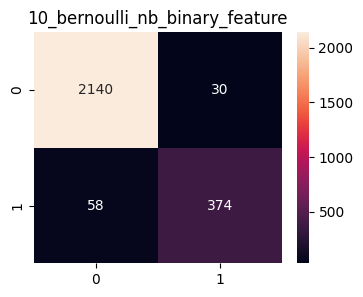

In [37]:
accuracy, spam_precision, spam_recall = get_model_report(train_data_featurized, '10_bernoulli_nb_binary_feature_predicted_class')

Classification accuracy: 96.46%
Spam precision: 98.02%
Spam recall: 80.32%


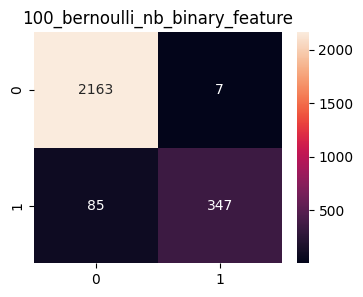

In [38]:
accuracy, spam_precision, spam_recall = get_model_report(train_data_featurized, '100_bernoulli_nb_binary_feature_predicted_class')

Classification accuracy: 94.5%
Spam precision: 98.01%
Spam recall: 68.29%


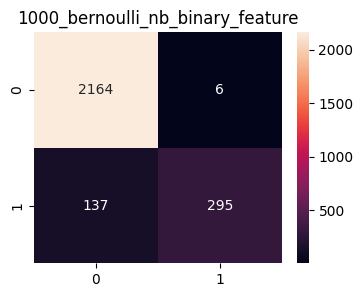

In [39]:
accuracy, spam_precision, spam_recall = get_model_report(train_data_featurized, '1000_bernoulli_nb_binary_feature_predicted_class')

Classification accuracy: 94.85%
Spam precision: 88.64%
Spam recall: 79.59%


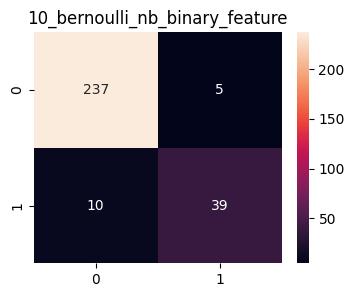

In [40]:
accuracy, spam_precision, spam_recall = get_model_report(test_data_featurized, '10_bernoulli_nb_binary_feature_predicted_class')
summary_dict.append({'model': 'bernoulli NB', 'num_features': 10, 'accuracy': accuracy, 'spam_precision': spam_precision, 'spam_recall': spam_recall})

Classification accuracy: 94.5%
Spam precision: 100.0%
Spam recall: 67.35%


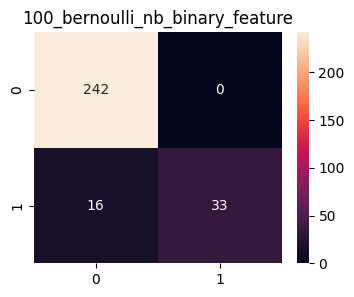

In [41]:
accuracy, spam_precision, spam_recall = get_model_report(test_data_featurized, '100_bernoulli_nb_binary_feature_predicted_class')
summary_dict.append({'model': 'bernoulli NB', 'num_features': 100, 'accuracy': accuracy, 'spam_precision': spam_precision, 'spam_recall': spam_recall})

Classification accuracy: 93.47%
Spam precision: 100.0%
Spam recall: 61.22%


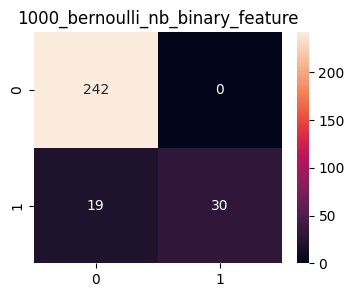

In [42]:
accuracy, spam_precision, spam_recall = get_model_report(test_data_featurized, '1000_bernoulli_nb_binary_feature_predicted_class')
summary_dict.append({'model': 'bernoulli NB', 'num_features': 1000, 'accuracy': accuracy, 'spam_precision': spam_precision, 'spam_recall': spam_recall})

### Part 2.3 $-$ Multinomial NB with binary features

Multinomial Classifier basically ignores the negative evidence.

$$
\frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}}
$$

Here, we need to calculate $p(t|c)=\frac{1+M_{t,c}}{m+M_{c}}$

We can calculate a ratio to decide the class

In [43]:
def calculate_tf_prob_vector(top_words: list[str], emails: dict) -> list[float]:
    '''
    Inputs:
        - top_words: bag of words to calculate term frequency probability
        - emails: list of emails to search the word

    Caveats:
        - Laplace smoothing is used to calculate the probability

    Returns:
        - probability of term frequency of words in given emails
    '''
    num_words = len(top_words)
    word_freq = [sum(email.count(word) for email in emails) for word in top_words]
    total_freq = sum(word_freq)
    return [(word_freq[i] + 1) / (total_freq + num_words) for i in range(num_words)]

In [44]:
def classify_MultinomialNB_binary_features(feature_vector: list[int], spam_prob_vector: list[float], nonspam_prob_vector: list[float], prior_spam_prob: float=p_spam_prior) -> int:
    '''
    Inputs:
        - feature_vector: list of features created from words
        - spam_prob_vector: list of probabilities corresponding to feature_vector created from the spam class
        - nonspam_prob_vector: list of probabilities corresponding to feature_vector created from the non-spam class
        - prior_spam_prob: prior probability of spam classification

    Returns:
        - predicted class (0, 1) of the email based on feature_vector and prob_vector
    '''
    posterior_spam_prob = prior_spam_prob
    posterior_nonspam_prob = 1 - prior_spam_prob

    for i, x_i in enumerate(feature_vector):
        posterior_spam_prob *= np.power(spam_prob_vector[i], x_i)
        posterior_nonspam_prob *= np.power(nonspam_prob_vector[i], x_i)

    return int(posterior_spam_prob / posterior_nonspam_prob > 1)

In [45]:
for N in [10, 100, 1000]:
    top_words = sorted_words_by_ig[:N]
    multinomial_tf_spam_prob_vector = calculate_tf_prob_vector(top_words, classified_train_emails[1])
    multinomial_tf_nonspam_prob_vector = calculate_tf_prob_vector(top_words, classified_train_emails[0])
    for contents in train_data_featurized.values():
        mutlinomial_nb_pred = classify_MultinomialNB_binary_features(
            feature_vector=contents[f'binary_feature_{N}'],
            spam_prob_vector=multinomial_tf_spam_prob_vector,
            nonspam_prob_vector=multinomial_tf_nonspam_prob_vector,
            prior_spam_prob=p_spam_prior
        )
        contents[f'{N}_multinomial_nb_binary_feature_predicted_class'] = mutlinomial_nb_pred
    print(f'Predictions made for top {N} features!!!')

Predictions made for top 10 features!!!
Predictions made for top 100 features!!!
Predictions made for top 1000 features!!!


In [46]:
for N in [10, 100, 1000]:
    top_words = sorted_words_by_ig[:N]
    multinomial_tf_spam_prob_vector = calculate_tf_prob_vector(top_words, classified_train_emails[1])
    multinomial_tf_nonspam_prob_vector = calculate_tf_prob_vector(top_words, classified_train_emails[0])
    for contents in test_data_featurized.values():
        mutlinomial_nb_pred = classify_MultinomialNB_binary_features(
            feature_vector=contents[f'binary_feature_{N}'],
            spam_prob_vector=multinomial_tf_spam_prob_vector,
            nonspam_prob_vector=multinomial_tf_nonspam_prob_vector,
            prior_spam_prob=p_spam_prior
        )
        contents[f'{N}_multinomial_nb_binary_feature_predicted_class'] = mutlinomial_nb_pred
    print(f'Predictions made for top {N} features!!!')

Predictions made for top 10 features!!!
Predictions made for top 100 features!!!
Predictions made for top 1000 features!!!


Classification accuracy: 96.16%
Spam precision: 87.73%
Spam recall: 89.35%


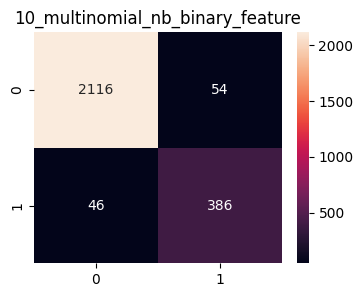

In [47]:
accuracy, spam_precision, spam_recall = get_model_report(train_data_featurized, '10_multinomial_nb_binary_feature_predicted_class')

Classification accuracy: 98.65%
Spam precision: 93.63%
Spam recall: 98.61%


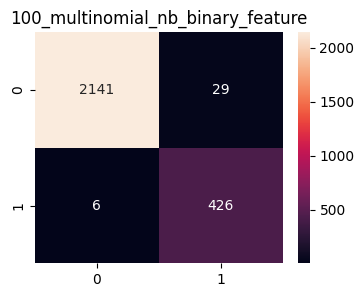

In [48]:
accuracy, spam_precision, spam_recall = get_model_report(train_data_featurized, '100_multinomial_nb_binary_feature_predicted_class')

Classification accuracy: 95.47%
Spam precision: 93.85%
Spam recall: 77.78%


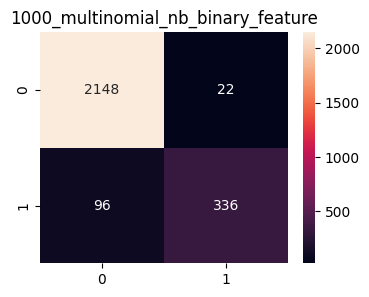

In [49]:
accuracy, spam_precision, spam_recall = get_model_report(train_data_featurized, '1000_multinomial_nb_binary_feature_predicted_class')

Classification accuracy: 95.19%
Spam precision: 83.02%
Spam recall: 89.8%


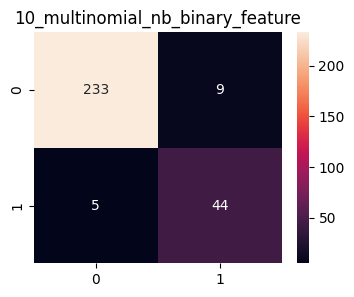

In [50]:
accuracy, spam_precision, spam_recall = get_model_report(test_data_featurized, '10_multinomial_nb_binary_feature_predicted_class')
summary_dict.append({'model': 'multinomial NB', 'num_features': 10, 'accuracy': accuracy, 'spam_precision': spam_precision, 'spam_recall': spam_recall})

Classification accuracy: 97.94%
Spam precision: 95.74%
Spam recall: 91.84%


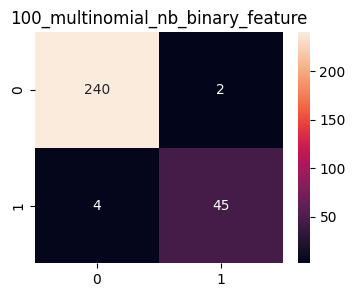

In [51]:
accuracy, spam_precision, spam_recall = get_model_report(test_data_featurized, '100_multinomial_nb_binary_feature_predicted_class')
summary_dict.append({'model': 'multinomial NB', 'num_features': 100, 'accuracy': accuracy, 'spam_precision': spam_precision, 'spam_recall': spam_recall})

Classification accuracy: 97.25%
Spam precision: 100.0%
Spam recall: 83.67%


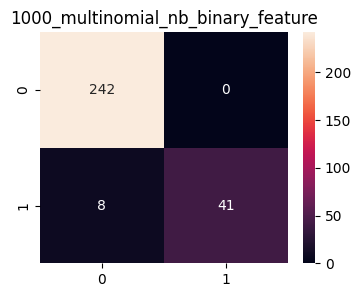

In [52]:
accuracy, spam_precision, spam_recall = get_model_report(test_data_featurized, '1000_multinomial_nb_binary_feature_predicted_class')
summary_dict.append({'model': 'multinomial NB', 'num_features': 1000, 'accuracy': accuracy, 'spam_precision': spam_precision, 'spam_recall': spam_recall})

### Part 2.4 $-$ Multinomial NB with term frequency (TF) features


For this classifier, we need to know how many times it occurs in the email for each word $-$

$$
\Rightarrow \frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}}
$$

Here, $x_i$ is the number of times any character appears in the email

In [53]:
for N in [10, 100, 1000]:
    top_words = sorted_words_by_ig[:N]
    multinomial_tf_spam_prob_vector = calculate_tf_prob_vector(top_words, classified_train_emails[1])
    multinomial_tf_nonspam_prob_vector = calculate_tf_prob_vector(top_words, classified_train_emails[0])
    for contents in train_data_featurized.values():
        mutlinomial_nb_pred = classify_MultinomialNB_binary_features(
            feature_vector=contents[f'tf_feature_{N}'],
            spam_prob_vector=multinomial_tf_spam_prob_vector,
            nonspam_prob_vector=multinomial_tf_nonspam_prob_vector,
            prior_spam_prob=p_spam_prior
        )
        contents[f'{N}_multinomial_nb_tf_feature_predicted_class'] = mutlinomial_nb_pred
    print(f'Predictions made for top {N} features!!!')

Predictions made for top 10 features!!!
Predictions made for top 100 features!!!
Predictions made for top 1000 features!!!


In [54]:
for N in [10, 100, 1000]:
    top_words = sorted_words_by_ig[:N]
    multinomial_tf_spam_prob_vector = calculate_tf_prob_vector(top_words, classified_train_emails[1])
    multinomial_tf_nonspam_prob_vector = calculate_tf_prob_vector(top_words, classified_train_emails[0])
    for contents in test_data_featurized.values():
        mutlinomial_nb_pred = classify_MultinomialNB_binary_features(
            feature_vector=contents[f'tf_feature_{N}'],
            spam_prob_vector=multinomial_tf_spam_prob_vector,
            nonspam_prob_vector=multinomial_tf_nonspam_prob_vector,
            prior_spam_prob=p_spam_prior
        )
        contents[f'{N}_multinomial_nb_tf_feature_predicted_class'] = mutlinomial_nb_pred
    print(f'Predictions made for top {N} features!!!')

Predictions made for top 10 features!!!
Predictions made for top 100 features!!!
Predictions made for top 1000 features!!!


Classification accuracy: 96.27%
Spam precision: 88.15%
Spam recall: 89.58%


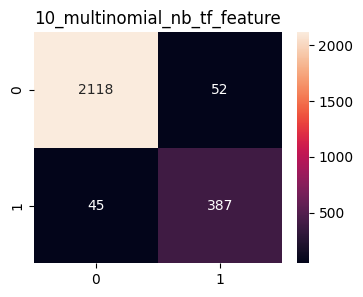

In [55]:
accuracy, spam_precision, spam_recall = get_model_report(train_data_featurized, '10_multinomial_nb_tf_feature_predicted_class')

Classification accuracy: 96.96%
Spam precision: 92.12%
Spam recall: 89.35%


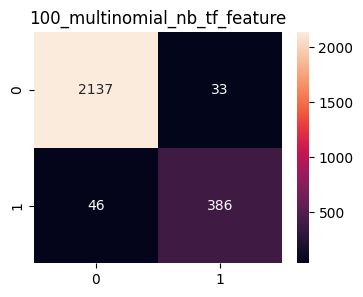

In [56]:
accuracy, spam_precision, spam_recall = get_model_report(train_data_featurized, '100_multinomial_nb_tf_feature_predicted_class')

Classification accuracy: 93.16%
Spam precision: 93.2%
Spam recall: 63.43%


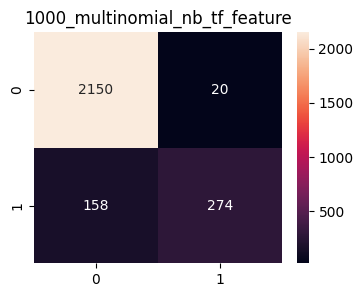

In [57]:
accuracy, spam_precision, spam_recall = get_model_report(train_data_featurized, '1000_multinomial_nb_tf_feature_predicted_class')

Classification accuracy: 95.88%
Spam precision: 84.91%
Spam recall: 91.84%


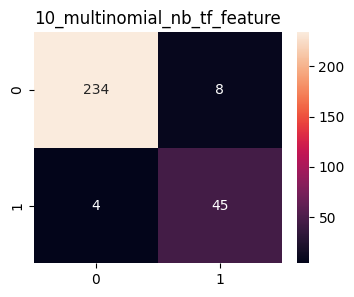

In [58]:
accuracy, spam_precision, spam_recall = get_model_report(test_data_featurized, '10_multinomial_nb_tf_feature_predicted_class')
summary_dict.append({'model': 'multinomial tf NB', 'num_features': 10, 'accuracy': accuracy, 'spam_precision': spam_precision, 'spam_recall': spam_recall})

Classification accuracy: 98.28%
Spam precision: 97.83%
Spam recall: 91.84%


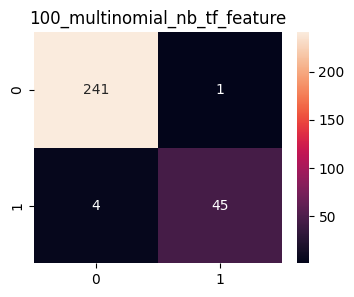

In [59]:
accuracy, spam_precision, spam_recall = get_model_report(test_data_featurized, '100_multinomial_nb_tf_feature_predicted_class')
summary_dict.append({'model': 'multinomial tf NB', 'num_features': 100, 'accuracy': accuracy, 'spam_precision': spam_precision, 'spam_recall': spam_recall})

Classification accuracy: 94.5%
Spam precision: 100.0%
Spam recall: 67.35%


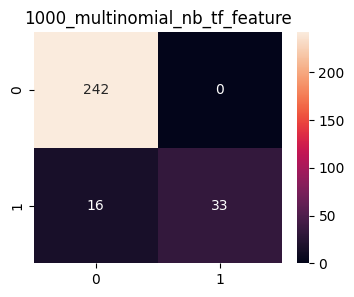

In [60]:
accuracy, spam_precision, spam_recall = get_model_report(test_data_featurized, '1000_multinomial_nb_tf_feature_predicted_class')
summary_dict.append({'model': 'multinomial tf NB', 'num_features': 1000, 'accuracy': accuracy, 'spam_precision': spam_precision, 'spam_recall': spam_recall})

## Part 3: SVM Classifier Implementation

We use hyperparameter tuning on kernel, gamma and C parameters of the SVM Classifier from sklearn with 5-fold cross-validation for selecting the best model used for each type of feature vector. The model is built to get better recall.

In [62]:
PARAMS = {
    'kernel': ['linear', 'rbf'],
    'gamma': [1e-5, 1e-2, 1, 100],
    'C': [1, 10, 100, 1000]
}

svm_summary_dict = []
model_dict = {}
y_train = [contents['actual_class'] for contents in train_data_featurized.values()]
y_test = [contents['actual_class'] for contents in test_data_featurized.values()]

for N in [10, 100, 1000]:
    model_dict[N] = {}
    for feat_type in ['binary', 'tf']:
        X_train = [contents[f'{feat_type}_feature_{N}'] for contents in train_data_featurized.values()]
        X_test = [contents[f'{feat_type}_feature_{N}'] for contents in test_data_featurized.values()]

        cv = GridSearchCV(
            estimator=svm.SVC(),
            param_grid=PARAMS,
            scoring='recall',
            cv=5,
            n_jobs=-1
        )

        cv.fit(X_train, y_train)
        model_dict[feat_type] = cv
        y_pred = cv.predict(X_test)

        cf_matrix = confusion_matrix(y_test, y_pred)
        accuracy = round((cf_matrix[0, 0] + cf_matrix[1, 1]) / sum(sum(cf_matrix)) * 100, 2)
        spam_precision = round(cf_matrix[1, 1]/sum(cf_matrix[:, 1]) * 100, 2)
        spam_recall = round(cf_matrix[1, 1]/sum(cf_matrix[1, :]) * 100, 2)
        svm_summary_dict.append(
            {
                'feat_type': feat_type,
                'num_features': N,
                'best_parameters': cv.best_params_,
                'accuracy': accuracy,
                'spam_precision': spam_precision,
                'spam_recall': spam_recall
            }
        )
        print(f"Predictions for {N} {feat_type} features done!!!")

Predictions for 10 binary features done!!!
Predictions for 10 tf features done!!!
Predictions for 100 binary features done!!!
Predictions for 100 tf features done!!!
Predictions for 1000 binary features done!!!
Predictions for 1000 tf features done!!!


In [64]:
svm_summary_df = pd.DataFrame(svm_summary_dict).sort_values('spam_precision', ascending=False)
svm_summary_df.style.background_gradient()

,feat_type,num_features,best_parameters,accuracy,spam_precision,spam_recall
4,binary,1000,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",96.560000,97.560000,81.630000
2,binary,100,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",96.220000,97.500000,79.590000
3,tf,100,"{'C': 10, 'gamma': 1e-05, 'kernel': 'linear'}",95.880000,93.020000,81.630000
5,tf,1000,"{'C': 1, 'gamma': 1e-05, 'kernel': 'linear'}",95.530000,89.130000,83.670000
1,tf,10,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",94.160000,88.100000,75.510000
0,binary,10,"{'C': 1, 'gamma': 100, 'kernel': 'rbf'}",92.780000,78.000000,79.590000


In [65]:
best_num_features = svm_summary_df['num_features'].iloc[0]
best_feat_type = svm_summary_df['feat_type'].iloc[0]
best_params = svm_summary_df['best_parameters'].iloc[0]
best_recall = svm_summary_df['spam_recall'].iloc[0]
best_precision = svm_summary_df['spam_precision'].iloc[0]

## Submissions

### Top 10 words

In [66]:
print(f"Top 10 words according to Information Gain: {top10_words}")

Top 10 words according to Information Gain: ['language', 'remove', 'free', 'linguistic', 'university', 'money', 'click', 'market', 'our', 'business']


### Naive Bayes Classifier metrics

In [67]:
pd.DataFrame(summary_dict)

,model,num_features,accuracy,spam_precision,spam_recall
0,bernoulli NB,10,94.85,88.64,79.59
1,bernoulli NB,100,94.50,100.00,67.35
2,bernoulli NB,1000,93.47,100.00,61.22
3,multinomial NB,10,95.19,83.02,89.80
4,multinomial NB,100,97.94,95.74,91.84
5,multinomial NB,1000,97.25,100.00,83.67
6,multinomial tf NB,10,95.88,84.91,91.84
7,multinomial tf NB,100,98.28,97.83,91.84
8,multinomial tf NB,1000,94.50,100.00,67.35


### SVM classifier

Methodology:
* Feature Selection: We take all binary and tf features of the top N (10, 100, 1000) words determined using the Information Gain metric
* Hyper-parameter tuning: Hyperparameter tuning is done for selecting optimal values for the kernel, C and gamma parameters with 5-fold cross-validation and recall as the scoring parameter
* The model with the highest precision is selected

In [69]:
print()

print(f"Parameters for the best SVM model: {best_params}")
print(f"Precision of the best SVM model: {best_precision}")
print(f"Recall of the best SVM model: {best_recall}")


Parameters for the best SVM model: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Precision of the best SVM model: 97.56
Recall of the best SVM model: 81.63
